# 3. Inference phase: corresponds to testing the model on the server. This step is performed as validation.
#### In the later step we will download the models to perform real time inference on the local machine.
#### In this way we can train model on the cloud with big data and deploy them in the real time environment.

In [4]:
#from pyspark import SparkConf, SparkContext
#from pyspark.sql import SQLContext
from pyspark.sql.types import *
from pyspark.sql import functions as F
from pyspark.ml.feature import MinMaxScalerModel
from pyspark.ml.feature import PCAModel
from pyspark.ml.feature import RFormulaModel

from pyspark.ml import PipelineModel
from pyspark.ml.regression import AFTSurvivalRegressionModel
from pyspark.ml.regression import LinearRegressionModel
from pyspark.ml.regression import GBTRegressionModel
from pyspark.ml.regression import DecisionTreeRegressionModel
from pyspark.ml.regression import RandomForestRegressionModel
from pyspark.ml.evaluation import RegressionEvaluator
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
!pip install numpy

Please see https://github.com/pypa/pip/issues/5599 for advice on fixing the underlying issue.
To avoid this problem you can invoke Python with '-m pip' instead of running pip directly.
Defaulting to user installation because normal site-packages is not writeable


#  Load the models

In [5]:
model_dir = '/tmp/morepro/models'
pipeline_model = PipelineModel.load(model_dir+'pipeline')
aft_model = AFTSurvivalRegressionModel.load(model_dir+'aft')
lr_model = LinearRegressionModel.load(model_dir+'lr')
dt_model = DecisionTreeRegressionModel.load(model_dir+'dt')
gbt_model = GBTRegressionModel.load(model_dir+'gbt')
rf_model = RandomForestRegressionModel.load(model_dir+'rf')


# Load the test data

In [6]:
df_test = spark.read.format("csv")\
    .option("delimiter", ",")\
    .option("header", "True")\
    .load('/tmp/morepro/data/test_df.csv',inferSchema= True)\
    .drop('_c0')

In [ ]:
rul = pd.read_csv('/home/students/s281654/Data/test_rul.csv')

# Transform the data and make predictions

In [198]:
test_transformedData = pipeline_model.transform(df_test)
aft_pred = aft_model.transform(test_transformedData)
lr_pred = lr_model.transform(test_transformedData)
dt_pred = dt_model.transform(test_transformedData)
gbt_pred = gbt_model.transform(test_transformedData)
rf_pred = rf_model.transform(test_transformedData)

# prediction vs rul

In [199]:
y_aft = np.array(aft_pred.select('prediction').collect())
y_lr = np.array(lr_pred.select('prediction').collect())
y_dt = np.array(dt_pred.select('prediction').collect())
y_rf = np.array(dt_pred.select('prediction').collect())
y_gbt = np.array(gbt_pred.select('prediction').collect())

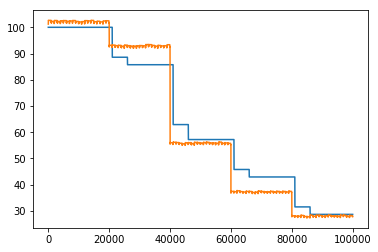

In [201]:
plt.plot(rul,label= 'rul')
plt.plot(y_lr[0:-1],label='prediction')

# Metric evaluation

In [ ]:
predictions = [lr_pred,dt_pred,rf_pred,gbt_pred,aft_pred]
names = ['linear_regression', 'decision_tree','random_forest','gradient_boosting_tree','survival_regression']

# MAE

In [41]:
evaluator = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="mae")
for name,preds in zip(names,predictions):
    print("%s MAE on test data = %g" % (name,evaluator.evaluate(preds)))

linear_regression MAE on test data = 4.40019
decision_tree MAE on test data = 4.63777
random_forest MAE on test data = 6.31273
gradient_boosting_tree MAE on test data = 5.60826
survival_regression MAE on test data = 9.00669


# MSE

In [42]:
evaluator = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="mse")
for name,preds in zip(names,predictions):
    print("%s MSE on test data = %g" % (name,evaluator.evaluate(preds)))

linear_regression MSE on test data = 32.2751
decision_tree MSE on test data = 57.6234
random_forest MSE on test data = 63.2176
gradient_boosting_tree MSE on test data = 62.4663
survival_regression MSE on test data = 138.355


# R2-Score

In [43]:
evaluator = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="r2")
for name,preds in zip(names,predictions):
    print("%s R2 on test data = %g" % (name,evaluator.evaluate(preds)))

linear_regression R2 on test data = 0.953311
decision_tree R2 on test data = 0.916642
random_forest R2 on test data = 0.908549
gradient_boosting_tree R2 on test data = 0.909636
survival_regression R2 on test data = 0.799856


# Save models to gateway serever
#### We can dowload the models from gateway file system to local file system and perform real time streaming locally using kafka.
#### Syntax: !hdfs dfs -get [model_path] [gateway_dir]

In [117]:
#!rm -rf /home/students/s281654/MorePro/modelspipeline
!hdfs dfs -get '/tmp/morepro/modelspipeline' '/home/students/s281654/MorePro'
!hdfs dfs -get '/tmp/morepro/modelslr' '/home/students/s281654/MorePro'
#!hdfs dfs -get '/tmp/morepro/modelsdt' '/home/students/s281654/MorePro'
#!hdfs dfs -get '/tmp/morepro/modelsgbt' '/home/students/s281654/MorePro'
#!hdfs dfs -get '/tmp/morepro/modelsrf' '/home/students/s281654/MorePro'
#!hdfs dfs -get '/tmp/morepro/modelsaft' '/home/students/s281654/MorePro'

#### Saving the test data to gateway

In [130]:
#!hdfs dfs -get '/tmp/morepro/data/test_df.csv' '/home/students/s281654/Data'